In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [11]:
!cp -r /content/drive/My\ Drive/Colab\ Notebooks/kaggle/titanic/data/ .
!cp -r data/ /content/drive/My\ Drive/Colab\ Notebooks/kaggle/titanic/

!cp -r /content/drive/My\ Drive/Colab\ Notebooks/kaggle/titanic/model/ .
!cp -r model/ /content/drive/My\ Drive/Colab\ Notebooks/kaggle/titanic/

!ls data/

test.csv  train.csv


In [12]:
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# データを読み込んで眺めてみる

In [13]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

- PassengerID:  乗客ID
- Survived: 　　生存結果 (1: 生存, 0: 死亡)　
- Pclass: 　　　乗客の階級
- Name: 　　 　 乗客の名前
- Sex: 　　　　 性別
- Age: 　　　　 年齢
- SibSp 　　 　 兄弟、配偶者の数
- Parch 　　　　両親、子供の数
- Ticket 　　　 チケット番号
- Fare 　　　　 乗船料金
- Cabin 　　　　部屋番号
- Embarked 　　 乗船した港（Cherbourg、Queenstown、Southampton）

In [14]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


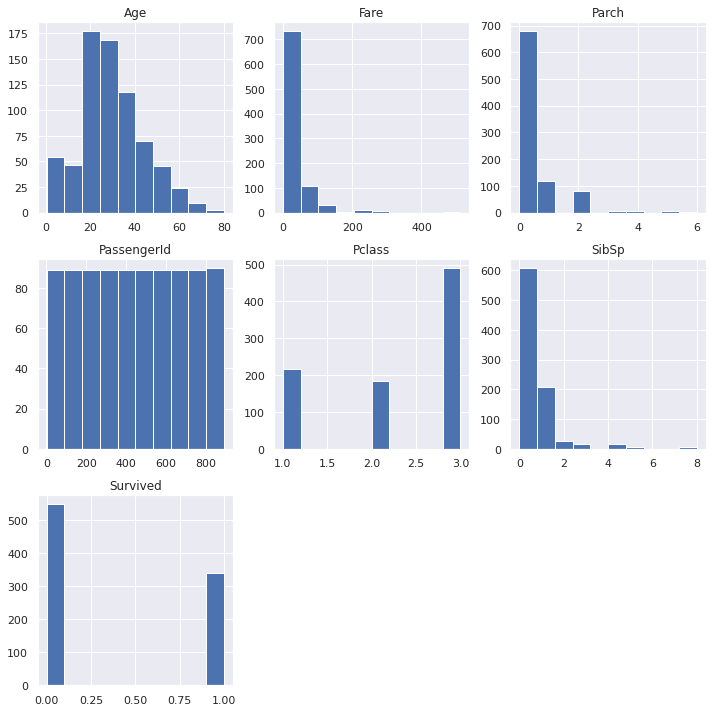

In [16]:
rcParams['figure.figsize'] = 10, 10
df_train.hist()
plt.tight_layout()    # グラフ同士が重ならないようにする関数
plt.show()

In [17]:
# 全体の生存率
df_train['Survived'].mean()

0.3838383838383838

categorical col: 'Name'
categorical col: 'Sex'
categorical col: 'Ticket'
categorical col: 'Cabin'
categorical col: 'Embarked'


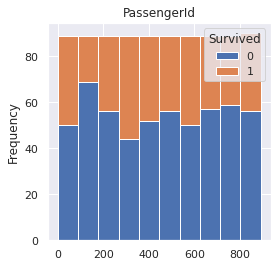

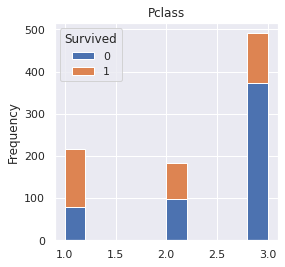

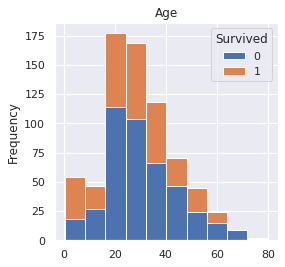

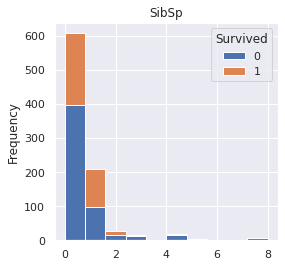

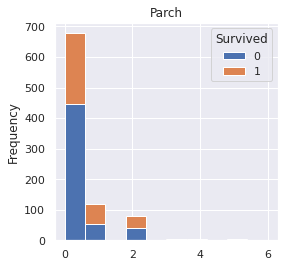

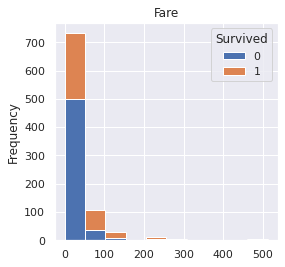

In [18]:
columns = df_train.columns[df_train.columns != 'Survived']
pvt = df_train.pivot_table(index=df_train.index, columns='Survived')

cat_cols = list()
for col in columns:
  try:
    ax = pvt.loc[:, col].plot(kind='hist', stacked=True, title=col, figsize=(4, 4))
  except Exception as e:
    # 連続値の説明変数はヒストグラムになるが、カテゴリ変数はならない。別のグラフを作成するために
    # それらのカラム名を取得しておく
    print('categorical col: {}'.format(e))
    cat_cols.append(col)

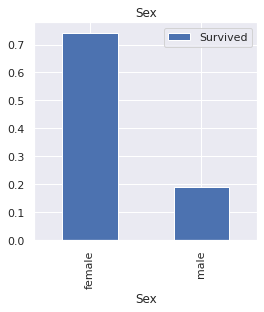

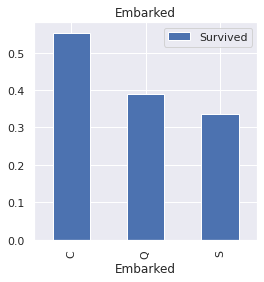

In [19]:
for col in cat_cols:
  # カテゴリの数が10未満の場合、生存率を出力する
  if len(set(df_train[col])) < 10:
    df_train[[col, 'Survived']].groupby(col).mean().plot(kind='bar', title=col, figsize=(4, 4))

# そのまま予測モデルに入れてみる

In [24]:
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

In [25]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [41]:
# 学習データを用意する。名前は関係ないと思うので説明変数から除く
X = df_train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]
y = df_train['Survived']

# カテゴリ変数をOne Hotベクトルに変換する
X = pd.get_dummies(X, columns=['Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked'])

In [43]:
X.shape[-1]

840

In [44]:
# モデルの作成
model = Sequential()
model.add(Dense(256, activation='sigmoid', input_shape=(X.shape[-1],))) # 入力層
model.add(Dense(128, activation='sigmoid')) # 隠れ層
model.add(Dropout(rate=0.5)) # ドロップアウト
model.add(Dense(1, activation='softmax')) # 出力層

In [46]:
# コンパイル
model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.1), metrics=['acc'])

In [47]:
# 学習
history = model.fit(X, y, batch_size=500, epochs=5, validation_split=0.2)

Epoch 1/5
2/2 [==============================] - 0s 114ms/step - loss: nan - acc: 0.5112 - val_loss: nan - val_acc: 0.6425
Epoch 2/5
2/2 [==============================] - 0s 27ms/step - loss: nan - acc: 0.6096 - val_loss: nan - val_acc: 0.6425
Epoch 3/5
2/2 [==============================] - 0s 24ms/step - loss: nan - acc: 0.6096 - val_loss: nan - val_acc: 0.6425
Epoch 4/5
2/2 [==============================] - 0s 28ms/step - loss: nan - acc: 0.6096 - val_loss: nan - val_acc: 0.6425
Epoch 5/5
2/2 [==============================] - 0s 29ms/step - loss: nan - acc: 0.6096 - val_loss: nan - val_acc: 0.6425


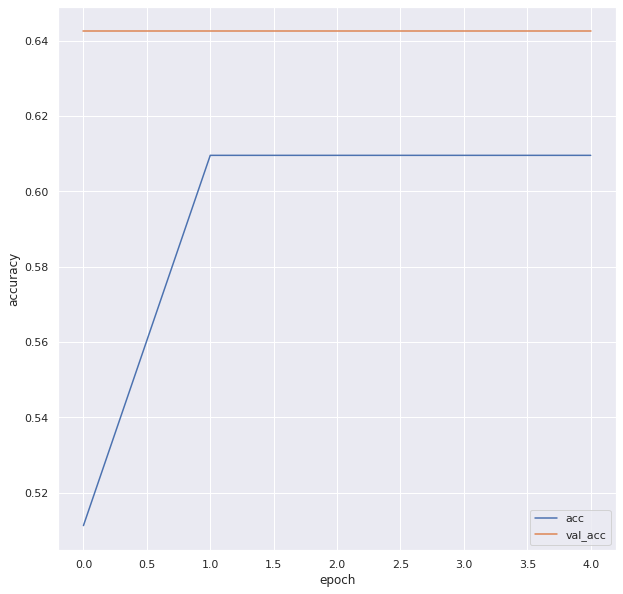

In [49]:
# グラフの表示
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')
plt.show()

In [50]:
!cp -r /content/drive/My\ Drive/Colab\ Notebooks/kaggle/titanic/data/ .
!cp -r data/ /content/drive/My\ Drive/Colab\ Notebooks/kaggle/titanic/

!cp -r /content/drive/My\ Drive/Colab\ Notebooks/kaggle/titanic/model/ .
!cp -r model/ /content/drive/My\ Drive/Colab\ Notebooks/kaggle/titanic/

!ls data/

test.csv  train.csv
